## How to train RT-DETR on dental radiographs ##

[![arXiv](https://img.shields.io/badge/arXiv-2304.08069-b31b1b.svg)](https://arxiv.org/pdf/2304.08069.pdf)
[![GitHub](https://badges.aleen42.com/src/github.svg)](https://github.com/lyuwenyu/RT-DETR)

RT-DETR, short for "Real-Time DEtection TRansformer", is a computer vision model developed by Peking University and Baidu. In their paper, "DETRs Beat YOLOs on Real-time Object Detection" the authors claim that RT-DETR can outperform YOLO models in object detection, both in terms of speed and accuracy. The model has been released under the Apache 2.0 license, making it a great option, especially for enterprise projects.

We will fine-tune the latest RT-DETRv2 model using a custom data set of panoramic x-rays. The original full data set is available from [Zenodo](https://zenodo.org/)

The original data set is available for download at the zenodo site: https://zenodo.org/records/7812323 .This data set is large (10 GB) and includes data not useful for training the object detection, such as validation images without annotations.

The full training set with annotations is here: https://dsets.s3.amazonaws.com/dentex/dentex-quadrant-enumeration.tar.gz

### Imports ###

In [1]:
import os
import glob
import numpy as np
import pandas as pd
from pathlib import Path
from matplotlib import pyplot as plt
from matplotlib import patches

# Imports from this package
# If you get an error, install the package in your python environment
# Do not forget to activate the environmen before running this command
# python -m pip install -e .

%load_ext autoreload
%autoreload 2
import computervision
from computervision.dentexdata import DentexData
from computervision.imageproc import ImageData

# Print package version
print(f'Computervision package version {computervision.__version__}')

Computervision package version 0.0.0


In [2]:
# Data directory (modify for local storage)
# This will be inside the root of the repository
data_dir = os.path.join(os.environ.get('HOME'), 'data')

# Directory to store the data set
dataset_dir = os.path.join(data_dir, 'dentex_detection')
Path(dataset_dir).mkdir(parents=True, exist_ok=True)

# Create an output directory to store examples and results
output_dir = os.path.join(dataset_dir, 'output')
Path(output_dir).mkdir(parents=True, exist_ok=True)

### Download and extract the data ####
Download the file from Zendo, store it in dataset_dir and extract. 
Or, you can use the dentex class to download the data with one line of code.

In [3]:
url = 'https://dsets.s3.amazonaws.com/dentex/dentex-quadrant-enumeration.tar.gz'
# Instantiate the DentexData class
# The class containes helper functions to simplify handling of the dentex data sets
dentex = DentexData(data_dir=dataset_dir)
file = dentex.download_image_data(url=url)

# This will extract the images and annotations into the dataset_dir directory
# You can find the data within the dentex_detection directory
image_dir = os.path.join(dataset_dir, 'quadrant_enumeration', 'xrays')

# There is also a json annotation file at the following location
annotation_file_name = 'train_quadrant_enumeration.json'
json_file = os.path.join(dataset_dir, 'quadrant_enumeration', annotation_file_name)

# Let's make sure that we have the expected number of images available
expected_images = 634
file_list = glob.glob(os.path.join(image_dir, '*.png'))
# We want to be sure that the number of images is correct before we continue
try:
    assert len(file_list) == expected_images
except AssertionError:
    print(f'Warning. Expected {expected_images} images in {image_dir}')
print(f'Found {len(file_list)} images in {image_dir}')

Extracting from .gz archive.
Uncompressed output file exists: /app/data/dentex_detection/dentex-quadrant-enumeration.tar. Skipping.
Found 634 images in /app/data/dentex_detection/quadrant_enumeration/xrays


### Load the annotations and convert into a pandas data frame ###

In [4]:
# The load_annotations method loads the annotations into a dictionary
annotations = dentex.load_annotations(json_file=json_file)
print(*list(annotations.keys()), sep='\n')

# The DentexData class contains a method "annotations_to_df"
# to conert the dictionary into a pandas data frame
df = dentex.annotations_to_df()

# We do not need all of the columns, so let's do some clean-up of the data frame
keep_cols = ['file_name', 'bbox', 'segmentation', 'category_id_1_name', 'category_id_2_name']
df = df[keep_cols].\
                rename(columns={'category_id_1_name': 'quadrant',
                                'category_id_2_name': 'position'}).\
                sort_values(by=['file_name', 'quadrant', 'position'], ascending=True).\
                reset_index(drop=True)
display(df.head())

images
annotations
categories_1
categories_2


,file_name,bbox,segmentation,quadrant,position
0,train_0.png,"[1376.5882352941176, 288.0, 102.94117647058829...","[[1467, 664, 1479, 288, 1388, 299, 1376, 655]]",1,1
1,train_0.png,"[1303.0588235294117, 293.88235294117646, 85.29...","[[1376, 670, 1388, 296, 1317, 293, 1314, 485, ...",1,2
2,train_0.png,"[1241.2941176470588, 255.6470588235294, 85.294...","[[1297, 623, 1326, 543, 1317, 258, 1244, 255, ...",1,3
3,train_0.png,"[1167.764705882353, 217.41176470588232, 114.70...","[[1232, 620, 1282, 564, 1253, 217, 1173, 226, ...",1,4
4,train_0.png,"[1079.5294117647059, 196.82352941176464, 100.0...","[[1147, 602, 1179, 564, 1176, 196, 1091, 217, ...",1,5


### Plot example images with annotations ###

In [5]:
def show_image_with_boxes(image, box_list, ax,
                          label_list=None, 
                          alpha=0.7, 
                          linewidth=2.5,
                          edgecolor=None):
    color = plt.cm.rainbow(np.linspace(0, 1, len(box_list)))
    color_list = [color[c] for c in range(len(color))]
    ax.imshow(image)
    for b, box in enumerate(box_list):
        if edgecolor is None:
            boxcolor = color_list[b]
        else:
            boxcolor = edgecolor
        # This is for COCO annotations
        # Change for other bounding box formats
        anchor = (box[0], box[1])
        width = box[2]
        height = box[3]
        rect = patches.Rectangle(xy=anchor, 
                                 width=width, 
                                 height=height, 
                                 linewidth=linewidth, 
                                 edgecolor=boxcolor, 
                                 facecolor='none', 
                                 alpha=alpha)
        ax.add_patch(rect)
        if label_list is not None:
            ax.text(x=anchor[0], y=anchor[1]-5, s=label_list[b], color=boxcolor)
    ax.set(xticks=[], yticks=[])
    return ax

/app/data/dentex_detection/quadrant_enumeration/xrays/train_109.png
(1316, 2856, 3)


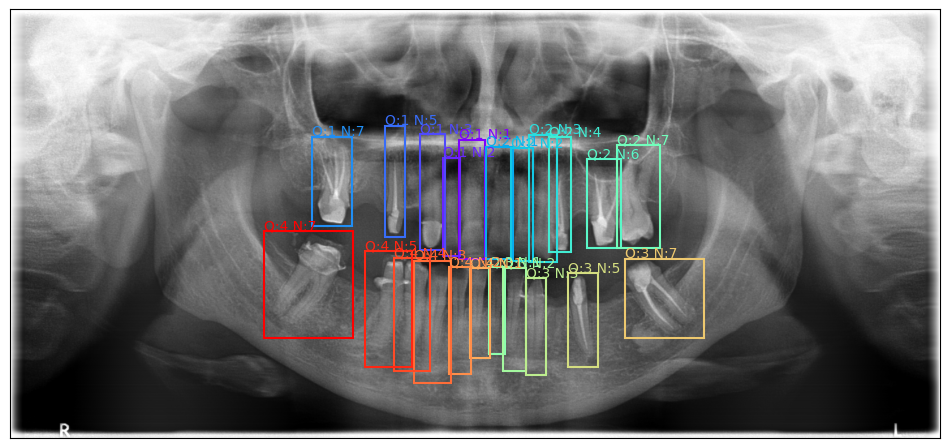

In [6]:
# Pick the file from the list
file = np.random.choice(file_list, size=1)[0]
print(file)
# Size of the output image
figsize = (12, 6)
file_name = os.path.basename(file)
# Create a file name for the output file
output_file_name = f'{os.path.splitext(file_name)[0]}_boxes.png'
output_file = os.path.join(output_dir, output_file_name)

bbox_list = df.loc[df['file_name']==file_name, 'bbox'].tolist()
quadrants = df.loc[df['file_name']==file_name, 'quadrant'].tolist()
positions = df.loc[df['file_name']==file_name, 'position'].tolist()
# Let's creata an appropriate label for each bounding box
label_list = [f'Q:{quadrant} N:{position}' for quadrant, position in zip(quadrants, positions)]
# Load the image
im = ImageData().load_image(file)
print(im.shape)
fig, ax = plt.subplots(figsize=figsize)
ax = show_image_with_boxes(image=im, 
                           box_list=bbox_list, 
                           ax=ax, 
                           label_list=label_list,
                           linewidth=1.5,
                           alpha=1.0)
plt.savefig(output_file, bbox_inches='tight')
plt.show()

In [7]:
# Save the data frame with the annotations
annotations_data_file_name = f'{os.path.basename(url).split('.')[0]}.parquet'
annotations_data_file = os.path.join(dataset_dir, annotations_data_file_name)
df.to_parquet(annotations_data_file)
print(f'Saved annotations data frame as: {annotations_data_file}')

Saved annotations data frame as: /app/data/dentex_detection/dentex-quadrant-enumeration.parquet
